In [2]:
!pip install causalml
!pip install duecredit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 11.7 MB/s eta 0:00:00


In [3]:
import causalml
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from causalml.inference.meta import BaseSLearner, BaseTLearner, BaseXLearner, BaseRLearner, BaseDRLearner

In [4]:
from causalml.dataset import synthetic_data

In [89]:
synthetic_data

<function causalml.dataset.regression.synthetic_data(mode=1, n=1000, p=5, sigma=1.0, adj=0.0)>

In [90]:
y, X, T, tau, b, e = synthetic_data(mode=1, n=1000, p=6)

In [91]:
X[:10]

array([[0.83646126, 0.6895582 , 0.14745821, 0.80672838, 0.43078313,
        0.72640799],
       [0.14214351, 0.73887039, 0.75695474, 0.83341715, 0.3506098 ,
        0.73417328],
       [0.45298021, 0.49637775, 0.26915889, 0.17049204, 0.53000009,
        0.5409325 ],
       [0.01117336, 0.31215493, 0.56900453, 0.57751314, 0.73415087,
        0.60621623],
       [0.44691815, 0.79487117, 0.77782593, 0.14583082, 0.38981131,
        0.27072851],
       [0.20991459, 0.78590679, 0.58563246, 0.67442978, 0.7187957 ,
        0.85807616],
       [0.72499651, 0.29917826, 0.48306003, 0.44224612, 0.6692471 ,
        0.57134467],
       [0.10969999, 0.96471344, 0.72207726, 0.23095301, 0.87972236,
        0.61071329],
       [0.64021837, 0.8527844 , 0.25967226, 0.39340934, 0.05743788,
        0.85667967],
       [0.30202757, 0.44803814, 0.56826363, 0.3431601 , 0.33274417,
        0.89564031]])

In [92]:
y[:10]

array([3.27260281, 2.16822381, 1.13809957, 0.6579043 , 1.18950404,
       1.16018823, 1.93959726, 0.95045089, 1.78925285, 1.74725276])

In [93]:
T[:10]

array([1, 1, 0, 0, 1, 1, 1, 0, 1, 0])

In [94]:
import matplotlib.pyplot as plt

In [95]:
X.shape, y.shape

((1000, 6), (1000,))

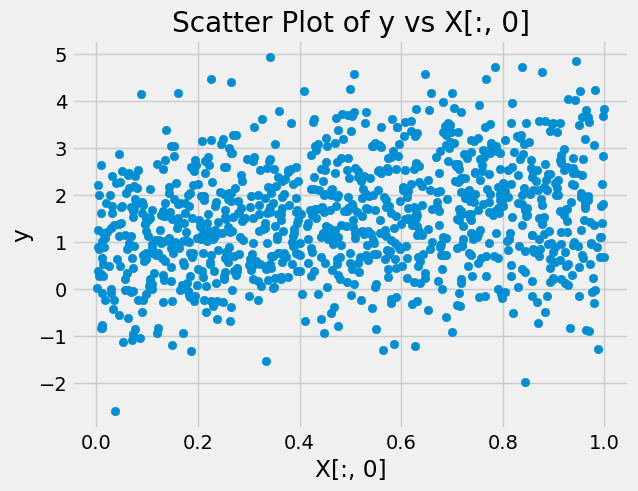

In [96]:
plt.scatter(X[:, 0], y)
plt.xlabel('X[:, 0]')
plt.ylabel('y')
plt.title('Scatter Plot of y vs X[:, 0]')
plt.show()

## 1. S-learner의 작동 원리
- 목적: 하나의 머신러닝 모델을 기반 학습기로 사용하여 결과 변수 Y의 조건부 기댓값을 추정한다.
- T의 처리: 처치 변수 T는 나머지 공변량 X과 마찬가지로 feature 중 하나로 사용한다.


In [97]:
# 선형회귀 모델을 기반학습기로 사용하는 Base S-learner 정의
lrs = BaseSLearner(learner = LinearRegression())

전체 데이터(공변량 X, 처치변수 T)를 사용해서 반응함수 $\hat\mu$ 를 학습시킨다.

In [98]:
# 반응함수 훈련
lrs.fit(X=X, treatment=T, y=y)

이제 학습된 1개의 모델 $\hat\mu$를 사용해서 처치 집단과 통제 집단에 대해 각각 예측 후 예측값의 차이를 구하자. <br>그것이 S-learner의 CATE 니까.

$ \hat{\tau}(x) = \hat{\mu}(x, T=1) - \hat{\mu}(x, T=0) $

In [99]:
help(lrs.predict)

Help on method predict in module causalml.inference.meta.slearner:

predict(X, treatment=None, y=None, p=None, return_components=False, verbose=True) method of causalml.inference.meta.slearner.BaseSLearner instance
    Predict treatment effects.
    Args:
        X (np.matrix or np.array or pd.Dataframe): a feature matrix
        treatment (np.array or pd.Series, optional): a treatment vector
        y (np.array or pd.Series, optional): an outcome vector
        return_components (bool, optional): whether to return outcome for treatment and control seperately
        verbose (bool, optional): whether to output progress logs
    Returns:
        (numpy.ndarray): Predictions of treatment effects.



In [100]:
'''
각 샘플에 대해 처치 효과를 예측한다. 즉 위 식에서 \hat{tau} 를 구하는 과정
return_components = False(default)인 경우 개별 샘플에 대한 CATE만 반환하고
return_components = True인 경우  CATE와 함께 처치집단과 통제집단 각각에 대한 예측된 결과값도 같이 반환한다
'''
individual_cate = lrs.predict(X=X, treatment=T, y=y, return_components=True)
individual_cate[0][:10]

array([[0.62900227],
       [0.62900227],
       [0.62900227],
       [0.62900227],
       [0.62900227],
       [0.62900227],
       [0.62900227],
       [0.62900227],
       [0.62900227],
       [0.62900227]])

왜 샘플별로 처치집단과 통제집단의 예측값은 다르지만 둘을 뺀 CATE는 모두 똑같은 값을 가지는 걸까?
<br>식으로 다시 돌아가보자.

- T=1일 때 예측값:
 $\hat{Y}(T=1, X) = \beta_0 + \beta_1 X_1 + ... + \beta_p X_p + \gamma (1) $

- T=0일 때 예측값:
$ \hat{Y}(T=0, X) = \beta_0 + \beta_1 X_1 + ... + \beta_p X_p + \gamma (0) $

- 둘을 뺀 값 = CATE
$ \hat{\tau}(X) = (\beta_0 + \beta_1 X_1 + ... + \beta_p X_p + \gamma) - (\beta_0 + \beta_1 X_1 + ... + \beta_p X_p + 0) $

<br>결국 $ \hat{\tau}(X) = \gamma $

처음에 S-learner의 기반 학습기로 선형 회귀 모델을 썼는데 여기에는 X와 T의 상호작용항이 없기 때문에 개별 샘플의 특성(X)에 따라서 처치 효과가 달라지지 않았기 때문에 모든 샘플에 대해 동일한 상수값 $\gamma$만으로 추정된 것.


In [101]:
help(lrs.estimate_ate)

Help on method estimate_ate in module causalml.inference.meta.slearner:

estimate_ate(X, treatment, y, p=None, return_ci=False, bootstrap_ci=False, n_bootstraps=1000, bootstrap_size=10000, pretrain=False) method of causalml.inference.meta.slearner.BaseSLearner instance
    Estimate the Average Treatment Effect (ATE).
    
    Args:
        X (np.matrix, np.array, or pd.Dataframe): a feature matrix
        treatment (np.array or pd.Series): a treatment vector
        y (np.array or pd.Series): an outcome vector
        return_ci (bool, optional): whether to return confidence intervals
        bootstrap_ci (bool): whether to return confidence intervals
        n_bootstraps (int): number of bootstrap iterations
        bootstrap_size (int): number of samples per bootstrap
        pretrain (bool): whether a model has been fit, default False.
    Returns:
        The mean and confidence interval (LB, UB) of the ATE estimate.



In [102]:
lrs.estimate_ate(X, T, y, return_ci=True)

(array([0.62900227]), array([0.49929808]), array([0.75870646]))

`lrs.estimate_ate()` 함수의 리턴값은 순서대로
- mean of ATE estimate: 개별 CATE가 모두 같기 이들의 평균도 당연히 같다.
- 신뢰구간의 하한
- 신뢰구간의 상한

### c.f. 기반 학습기를 상호작용항이 있는 비선형 모델로 바꿨을 때

In [103]:
# prompt: BaseSLearner 클래스를 불러와서 모델을 정의하고 synthetic_data로 정의해둔 데이터셋을 사용하여 fit, predict, estimate_ate를 한다. 대신 learner옵션을 상호작용항이 있는 비선형 모델을 사용한다

from sklearn.ensemble import RandomForestRegressor

# T와 X의 상호작용항이 있는 트리기반 모델 사용
rfr_slearner = BaseSLearner(learner = RandomForestRegressor(random_state=42))

rfr_slearner.fit(X=X, treatment=T, y=y)

individual_effects = rfr_slearner.predict(X=X, treatment=T, y=y)
print("Individual Treatment Effects (ITE):")
print(individual_effects[:10])

# 개별 샘플에 대한 ATE
ate_estimate = rfr_slearner.estimate_ate(X, T, y)
print("\nEstimated Average Treatment Effect (ATE):")
print(ate_estimate)

# ATE 추정
ate_estimate_ci = rfr_slearner.estimate_ate(X, T, y, return_ci=True)
print("\nEstimated Average Treatment Effect (ATE) with Confidence Interval:")
ate_estimate_ci

Individual Treatment Effects (ITE):
[[ 1.55261654]
 [ 0.63762961]
 [-0.15330133]
 [ 0.46659968]
 [ 0.57917634]
 [-0.02070364]
 [ 0.50087274]
 [-0.1790569 ]
 [-0.04247619]
 [-0.12072243]]

Estimated Average Treatment Effect (ATE):
[0.5152366]

Estimated Average Treatment Effect (ATE) with Confidence Interval:


(array([0.5152366]), array([0.44476108]), array([0.58571213]))

선형 모델을 사용했을 때와 달리 개별 샘플의 CATE 예측값이 달라진 것을 확인할 수 있다.

## 2. S-learner의 단점

- T가 다른 공변량 X들과 똑같은 피쳐 중 하나로 취급되기 때문에, T의 Y에 대한 예측력이 낮은 경우 정규화 과정에서 패널티를 먹어서 인과 효과가 과소추정 될 수 있다

- 심지어 트리 모델에서는 더 극단적으로 T가 분기 기준으로 한 번도 선택되지 못하면, 인과효과가 모두 0으로 추정될 수도 있다

### T의 예측력이 낮아 인과 효과가 과소추정 되는 사례

In [76]:
# 다른 공변량 X들에 비해 T의 예측력이 낮은 예시 데이터 생성
# X의 첫 번째 컬럼 (X[:, 0])이 y와 강한 상관관계를 가지도록 하고, T는 y와 거의 상관관계가 없도록 설정

def custom_synthetic_data(n=1000, p=6):
    X = np.random.rand(n, p) * 10 # X는 다양한 값을 가지도록

    # y를 X의 첫 번째 컬럼에 크게 의존하고, T에는 거의 의존하지 않도록 생성
    # tau: 처치 효과 (T=1일 때 y의 변화)
    # b: 공변량의 효과 (X가 y에 미치는 영향)
    # e: 처치 확률 (T=1이 될 확률)
    # T: 처치 변수 (0 또는 1)

    # X의 첫 번째 컬럼이 y에 큰 영향을 미치도록 b를 설정
    b = np.array([10.0] + [0.5] * (p - 1)) # X[:, 0]의 계수를 더 크게 설정

    # T는 y에 거의 영향을 미치지 않도록 tau를 설정
    # 하지만 실제 처치 효과는 존재 (예: true_tau = 1.0)
    true_tau = 1.0
    tau = np.ones(n) * true_tau

    # 처치 확률 (propensity score)은 X에 따라 달라지도록
    # 예시: X의 첫 번째 컬럼이 클수록 T=1이 될 확률이 높아지도록 설정
    e = 1 / (1 + np.exp(-(X[:, 0] - 5))) # 로지스틱 함수를 사용하여 0과 1 사이 값 생성

    # 각 샘플에 대해 처치(T)를 할당
    T = (np.random.rand(n) < e).astype(int)

    # 결과 변수 y 생성
    # y = b*X + tau*T + noise
    # 노이즈 수준을 조정하여 X의 강한 신호 속에서 T의 신호가 상대적으로 약하게 보이도록 함
    noise = np.random.randn(n) * 5 # 노이즈 추가
    y = X @ b + tau * T + noise

    return y, X, T, tau, b, e

In [84]:
# prompt: T에 대한 예측력이 다른 X에 비해 낮아서 정규화 과정에서 패널티를 받아 인과효과가 과소추정되는 예시를 만들어줘

from sklearn.linear_model import Lasso

# Custom synthetic data 생성
y, X, T, tau, b, e = custom_synthetic_data(n=1000, p=6)

# T의 예측력이 낮은지 확인하기 위해 T와 y의 상관관계 확인
print(f"Correlation between T and y: {np.corrcoef(T, y)[0, 1]:.4f}")
# X[:, 0]과 y의 상관관계 확인 (높게 나올 것으로 예상)
print(f"Correlation between X[:, 0] and y: {np.corrcoef(X[:, 0], y)[0, 1]:.4f}")

# S-learner 정의 및 학습
lrs = BaseSLearner(learner = Lasso(alpha=0.1))
lrs.fit(X=X, treatment=T, y=y)

# ATE 추정
ate_estimate, ate_lower_ci, ate_upper_ci = lrs.estimate_ate(X, T, y, return_ci=True)

print(f"\nTrue ATE (average of true tau): {np.mean(tau):.4f}")
print(f"S-learner ATE estimate: {ate_estimate[0]:.4f}")
print(f"S-learner ATE 95% CI: [{ate_lower_ci[0]:.4f}, {ate_upper_ci[0]:.4f}]")

Correlation between T and y: 0.7433
Correlation between X[:, 0] and y: 0.9790

True ATE (average of true tau): 1.0000
S-learner ATE estimate: 0.1714
S-learner ATE 95% CI: [-0.4613, 0.8040]


In [85]:
# T-learner를 사용하여 추정된 인과 효과를 비교
# T-learner는 처치 집단과 통제 집단을 분리하여 각각 별도의 모델을 학습시킴

lrt = BaseTLearner(learner=Lasso(alpha=0.1))
lrt.fit(X=X, treatment=T, y=y)
ate_estimate_t = lrt.estimate_ate(X, T, y) # T-learner는 fit에 T가 들어가므로 estimate에는 X만 필요
print("\nT-learner ATE estimate:{}".format(ate_estimate_t[0]))


T-learner ATE estimate:[1.09552108]


L1 정규화 패널티가 있는 Lasso모델을 사용하자, S-learner에서는 ATE 추정량이 실제 tau(1.0)보다 과소추정된 반면 T-learner에서는 그러한 과소추정이 일어나지 않은 것을 확인할 수 있다다.